## Overview

This notebook loads the movie rating data from DSX's local storage then it trains an *alternating least square* (ALS) model using Spark's Machine Learning library (MLlib).<br>
For more information on Spark ALS, see here:
- http://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#collaborative-filtering
- https://github.com/jadianes/spark-movie-lens

## Load the data

Again, let's preview the data

In [13]:
!head -3 ratings.dat
!echo
!tail -3 ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968

6040::562::5::956704746
6040::1096::4::956715648
6040::1097::4::956715569


The data is in the format:
    
`UserID::MovieID::Rating::Timestamp`
                        
Now load it into an RDD

In [14]:
from pyspark.mllib.recommendation import Rating

ratingsRDD = sc.textFile('ratings.dat') \
               .map(lambda l: l.split("::")) \
               .map(lambda p: Rating(
                                  user = int(p[0]), 
                                  product = int(p[1]),
                                  rating = float(p[2]), 
                                  )).cache()

It's useful to check some highlevel statistics on the data. At this point, I'm mainly interested in the row count.

In [15]:
ratingsRDD.toDF().describe().show()

+-------+------------------+------------------+------------------+
|summary|              user|           product|            rating|
+-------+------------------+------------------+------------------+
|  count|           1000209|           1000209|           1000209|
|   mean| 3024.512347919285|1865.5398981612843| 3.581564453029317|
| stddev|1728.4126948999951|1096.0406894572552|1.1171018453732544|
|    min|                 1|                 1|               1.0|
|    max|              6040|              3952|               5.0|
+-------+------------------+------------------+------------------+



## Split into training and testing

Next we split the data into training and testing data sets

In [16]:
(training, test) = ratingsRDD.randomSplit([0.8, 0.2])

numTraining = training.count()
numTest = test.count()

# verify row counts for each dataset
print("Total: {0}, Training: {1}, test: {2}".format(ratingsRDD.count(), numTraining, numTest))

Total: 1000209, Training: 800181, test: 200028


## Build the recommendation model using ALS on the training data

I've chosen some values for the ALS parameters.  You should probaly experiment with different values.

In [17]:
from pyspark.mllib.recommendation import ALS

rank = 50
numIterations = 20
lambdaParam = 0.1
model = ALS.train(training, rank, numIterations, lambdaParam)

Let's save the model ...

In [18]:
# if there is an existing model, delete it
!rm -rf ./recommender_model

# save the model
model.save(sc, './recommender_model')

Just for curiosities sake, let's see what the model looks like on the file system

In [19]:
!find ./recommender_model

./recommender_model
./recommender_model/metadata
./recommender_model/metadata/_SUCCESS
./recommender_model/metadata/._SUCCESS.crc
./recommender_model/metadata/.part-00000.crc
./recommender_model/metadata/part-00000
./recommender_model/data
./recommender_model/data/product
./recommender_model/data/product/_common_metadata
./recommender_model/data/product/_SUCCESS
./recommender_model/data/product/._metadata.crc
./recommender_model/data/product/part-r-00001-e6985118-2da0-45a6-8ba7-3b1c2f01a006.gz.parquet
./recommender_model/data/product/._SUCCESS.crc
./recommender_model/data/product/part-r-00000-e6985118-2da0-45a6-8ba7-3b1c2f01a006.gz.parquet
./recommender_model/data/product/._common_metadata.crc
./recommender_model/data/product/.part-r-00001-e6985118-2da0-45a6-8ba7-3b1c2f01a006.gz.parquet.crc
./recommender_model/data/product/_metadata
./recommender_model/data/product/.part-r-00000-e6985118-2da0-45a6-8ba7-3b1c2f01a006.gz.parquet.crc
./recommender_model/data/user
./recommender_model/data/u

## Evaluate the model

First we create a crude (baseline) model that takes the mean rating for the whole dataset.<br>
We can then compare the ALS model against the baseline model.

### Baseline predictions

Calculate Root Mean Squared Error (RMSE) when using the mean value of all ratings for the predicted rating

In [32]:
mean_rating = training.map(lambda x: x[2]).mean()

# we need to structure the (user, product (movie)) pairs with the mean rating
predictions = test.map(lambda r: ((r.user, r.product), mean_rating))

# predictions.take(2) looks like this:
# [((1, 1193), 3.581855855112805), ((1, 661), 3.581855855112805)]
# 
# I.e.
# [((user, movie), rating), ...]

ratesAndPreds = test.map(lambda r: ((r.user, r.product), r.rating)) \
                    .join(predictions)
    
# ratesAndPreds.take(2) looks like this: 
# [((4520, 2502), (3.0, 3.581855855112805)), ((1320, 1230), (5.0, 3.581855855112805))]
#
# I.e.    
# [((user, movie), (actual_rating, predicted_rating)), ...]
# 
# The (user, product (movie)) tuple is the key and the value is another tuple
# representing the actual rating and the mean rating.


# subtract the mean rating from the actual rating, square the result and take the 
# mean of the results
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

import math
RMSE = math.sqrt(MSE)

print("Mean Squared Error = " + str(MSE))
print("Root Mean Squared Error = " + str(RMSE))

Mean Squared Error = 1.24722764858
Root Mean Squared Error = 1.11679346729


### Spark recommendation predictions

Calculate Root Mean Squared Error (RMSE) when using spark ALS to predict ratings

In [33]:
# get a RDD that is a list of user + product (movie) pairs 
test_without_rating = test.map(lambda r: (r.user, r.product))


# pass the (user, product (movie)) pairs to the model to predict the values
predictions = model.predictAll(test_without_rating) \
                   .map(lambda r: ((r.user, r.product), r.rating))

# predictions.take(2) looks like this:
# [((4904, 2346), 4.138371476123861), ((4904, 2762), 5.076268198843158)]
# 
# I.e.
# [((user, movie), rating), ...]

# next we join the a RDD with the actual rating to the predicted rating
ratesAndPreds = test.map(lambda r: ((r.user, r.product), r.rating)) \
                    .join(predictions)

# ratesAndPreds.take(2) looks like this:
# [((4520, 2502), (3.0, 3.948614784605795)), ((1320, 1230), (5.0, 4.648257851849921))]
#
# I.e.
# [((user, movie), (actual_rating, predicted_rating)), ...]
# 
# The (user, product (movie)) tuple is the key and the value is another tuple
# representing the actual rating and the mean rating.    
    

# subtract the mean rating from the actual rating, square the result and take the 
# mean of the results
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    
import math
RMSE = math.sqrt(MSE)
    
print("Mean Squared Error = " + str(MSE))
print("Root Mean Squared Error = " + str(RMSE))

Mean Squared Error = 0.737909632146
Root Mean Squared Error = 0.859016665814


We can see that Spark's ALS RMSE is much lower than the baseline predictor - this is good news :)

### Visually explore squared error

Next let's plot the Squared Error (SE) from the Spark ALS model.<br>
First, split out the data for matplotlib.

In [34]:
from pyspark.sql.functions import min, max

user = predictions.map(lambda x: int(x[0][0])).cache()
movie = predictions.map(lambda x: int(x[0][1])).cache()
se = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).cache()

Next, let's plot the data

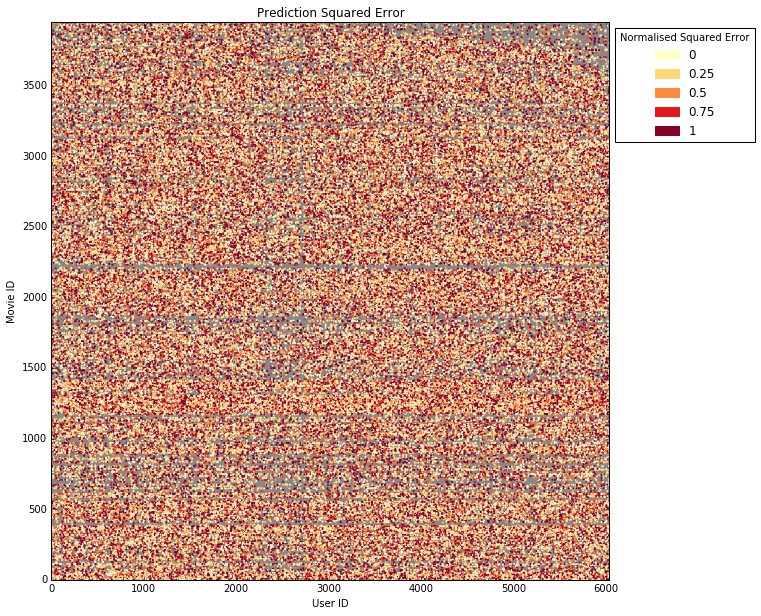

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

ratingsDF = ratingsRDD.toDF()

max_user = ratingsDF.select(max('user')).take(1)[0]['max(user)']
max_movie = ratingsDF.select(max('product')).take(1)[0]['max(product)']

width = 10
height = 10
plt.figure(figsize=(width, height))
plt.xlim([0,max_user])
plt.ylim([0,max_movie])
plt.xlabel('User ID')
plt.ylabel('Movie ID')
plt.title('Prediction Squared Error')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(se.collect())

plt.scatter(
    user.collect(), 
    movie.collect(), 
    s=1,
    edgecolor=colors)

plt.legend(
    title='Normalised Squared Error',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='0'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='0.25'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='0.5'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='0.75'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='1')    
    ])

plt.show()

As expected, the prediction errors seem to be fairly random.  <br>The main discernable pattern seems to be the grey areas, which represent no ratings.

We would probably want to dig into the grey areas - why do we have no predictions here?  <br> - Are there gaps in the movie IDs?  <br> - Do some movies have no ratings at all?